In [196]:
import os
import cv2
import itertools
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from keras.callbacks import EarlyStopping
from keras import backend as K

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout

import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner import HyperModel
from keras_tuner.tuners import Hyperband

from keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import GlobalAveragePooling2D

from tensorflow.python.keras.models import Sequential

from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler

from tensorflow import keras

In [3]:
# funtion to write predictions
def write_preds(preds, fname):
    pd.DataFrame({"id": list(range(1,len(preds)+1)), "label":   preds}).to_csv(fname, index=False)

In [4]:
print(os.listdir())

['.ipynb_checkpoints', 'Dog V. Cats Requirements.txt', 'sample_submission.csv', 'test', 'Thomas_Dogs_vs_Cats_Redux.ipynb', 'train']


In [5]:
category = ["cat", "dog"]

EPOCHS                  = 30
IMGSIZE                 = 128
BATCH_SIZE              = 64
STOPPING_PATIENCE       = 15
VERBOSE                 = 3
OPTIMIZER               = 'adam'


In [6]:
TRAIN_DIR = os.path.join('train')
TEST_DIR  = os.path.join('test')

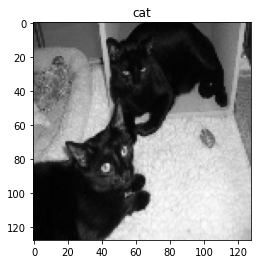

In [7]:
for img in os.listdir(TRAIN_DIR)[7890:]:
    img_path = os.path.join(TRAIN_DIR, img)
    img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_arr = cv2.resize(img_arr, (IMGSIZE, IMGSIZE))
    plt.imshow(img_arr, cmap='gray')
    plt.title(img.split('.')[0])
    break

In [8]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3])
    sns.countplot(labels)
    plt.title('Cats and Dogs')

In [9]:
#set a function for parsing the image names
def label_pet_image_one_hot_encoder(img):
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

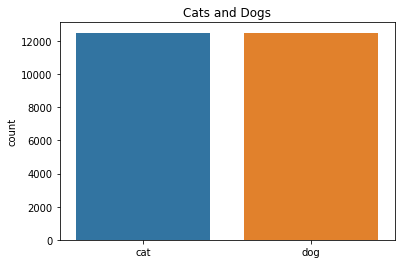

In [10]:
plot_image_list_count(os.listdir(TRAIN_DIR))

## Data Preparation

In [11]:
def create_train_data(path):
    X = []
    y = []
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_arr = cv2.resize(img_arr, (IMGSIZE, IMGSIZE))
        img_arr = img_arr / 255.0
        cat = np.where(img.split('.')[0] == 'dog', 1, 0)
        
        X.append(img_arr)
        y.append(cat)
    
    X = np.array(X).reshape(-1, IMGSIZE, IMGSIZE, 1)
    y = np.array(y)
    
    return X, y    

In [12]:
X, y = create_train_data(TRAIN_DIR)

print(f"features shape {X.shape}.\nlabel shape {y.shape}.")

features shape (25000, 128, 128, 1).
label shape (25000,).


In [13]:
y = to_categorical(y, 2)
print(f"features shape {X.shape}.\nlabel shape {y.shape}.")

features shape (25000, 128, 128, 1).
label shape (25000, 2).


In [14]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)
train_gen = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = train_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE)

In [299]:
im_test = []
c = 0
for img in os.listdir(TEST_DIR)[:12500]:
    c = c + 1
    img_path = os.path.join(TEST_DIR, img)
    img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_arr = cv2.resize(img_arr, (IMGSIZE, IMGSIZE))
    img_arr = img_arr / 255.0
    im_test.append(img_arr)
print(c) 

12500


In [300]:
im_test = np.array(im_test).reshape(-1, IMGSIZE, IMGSIZE, 1)

## MODEL 1

In [23]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(2, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)      

In [30]:
start = time.time()
modelfit1 = model1.fit(X_train, y_train, epochs=30,validation_split=0.2)
end = time.time()
print("Training took {:.2f}s".format(end - start))

Epoch 1/30
500/500 [==============================] - 233s 466ms/step - loss: 0.5386 - accuracy: 0.7293 - val_loss: 0.4941 - val_accuracy: 0.7763
Epoch 2/30
500/500 [==============================] - 234s 468ms/step - loss: 0.5031 - accuracy: 0.7601 - val_loss: 0.5045 - val_accuracy: 0.7533
Epoch 3/30
500/500 [==============================] - 231s 463ms/step - loss: 0.4759 - accuracy: 0.7747 - val_loss: 0.4838 - val_accuracy: 0.7613
Epoch 4/30
500/500 [==============================] - 230s 459ms/step - loss: 0.4546 - accuracy: 0.7845 - val_loss: 0.4795 - val_accuracy: 0.7690
Epoch 5/30
500/500 [==============================] - 230s 460ms/step - loss: 0.4327 - accuracy: 0.8006 - val_loss: 0.4556 - val_accuracy: 0.7805
Epoch 6/30
500/500 [==============================] - 232s 464ms/step - loss: 0.4193 - accuracy: 0.8056 - val_loss: 0.4007 - val_accuracy: 0.8195
Epoch 7/30
500/500 [==============================] - 229s 459ms/step - loss: 0.4017 - accuracy: 0.8188 - val_loss: 0.4063 -

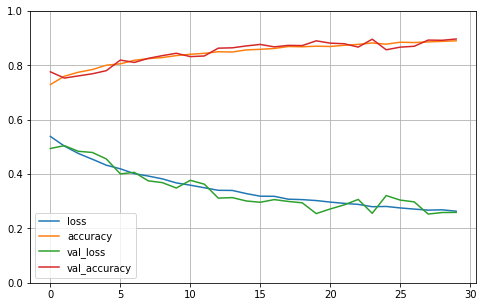

In [31]:
# Learning curves: the mean training loss and accuracy measured over each epoch, and the mean validation loss and 
# accuracy measured at the end of each epoch
pd.DataFrame(modelfit1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

#### The movement in the training and validation losses indicate that the learning rate was set too high.

In [32]:
model1.evaluate(X_test, y_test)

157/157 [==============================] - 20s 129ms/step - loss: 0.2462 - accuracy: 0.8936


[0.24620209634304047, 0.8935999870300293]

In [35]:
#create 1D array of y_test for validation
y_true = np.argmax(y_test, axis = 1)

In [ ]:
y_pred1 = model1.predict(X_test)
y_pred1_classes = np.argmax(y_pred1, axis=1)

In [104]:
report = classification_report(y_true, y_pred1_classes, output_dict=True)
result1 = pd.DataFrame(report).transpose()
result1


,precision,recall,f1-score,support
0,0.861792,0.938670,0.898589,2511.0000
1,0.932009,0.848132,0.888094,2489.0000
accuracy,0.893600,0.893600,0.893600,0.8936
macro avg,0.896900,0.893401,0.893342,5000.0000
weighted avg,0.896746,0.893600,0.893365,5000.0000


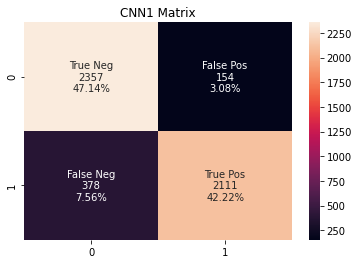

In [47]:
conf1 = confusion_matrix(y_true,y_pred1_classes)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf1.flatten()/np.sum(conf1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf1, annot=labels, fmt='')
plt.title('CNN1 Matrix')
plt.show()

In [88]:
#Create random classifier line for ROC and precision/recall curves
rnd_probs = [0 for _ in range(len(y_true))]
# calculate scores
rnd_auc = roc_auc_score(y_true, rnd_probs)
# calculate roc curves
rnd_fpr, rnd_tpr, _ = roc_curve(y_true, rnd_probs)
# calculate the random classifier line as the proportion of the positive class
rnd = len(y_true[y_true==1]) / len(y_true)

In [89]:
# predict probabilities for logistic regression
cnn1_probs = model1.predict_proba(X_test)
# keep probabilities for the positive outcome only
cnn1_probs = cnn1_probs[:,1]
# calculate scores
cnn1_auc = roc_auc_score(y_true, cnn1_probs)
cnn1_fpr, cnn1_tpr, _ = roc_curve(y_true, cnn1_probs)

Random Classifier: ROC AUC=0.500
Model1: ROC AUC=0.969


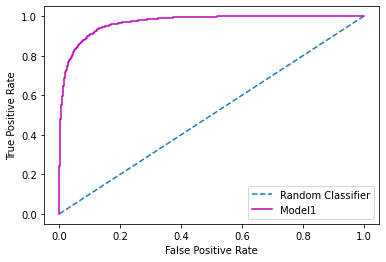

In [90]:
print('Random Classifier: ROC AUC=%.3f' % (rnd_auc))
print('Model1: ROC AUC=%.3f' % (cnn1_auc))
# plot the roc curve for the model
plt.plot(rnd_fpr, rnd_tpr, linestyle='--', label='Random Classifier')
plt.plot(cnn1_fpr, cnn1_tpr, marker='', label='Model1', color = 'm')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

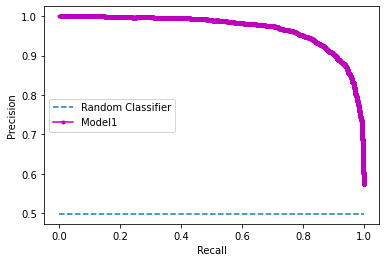

Model1: PR AUC=0.968


In [91]:
# plot the random classifier precision-recall curve
plt.plot([0, 1], [rnd, rnd], linestyle='--', label='Random Classifier')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, cnn1_probs)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='Model1', color = 'm')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
cnn1_pr_score = auc(recall, precision)
print('Model1: PR AUC=%.3f' % (cnn1_pr_score))

In [316]:
y_proba1 = model1.predict(im_test)
y_values1 = y_proba1[:,0]

In [317]:
write_preds(y_values1, "cnn1.csv")

#### Model 1 performed well with an AUC score of 96. The is would perform well as a classifier. This is likely due to the numerous trained epochs. A major weakness of this model was the training time. 

## Hyperparameter Tuning

In [257]:
K.clear_session()

In [247]:
INPUT_SHAPE = X.shape[1:]
es = EarlyStopping(monitor='val_loss', patience=5)

In [248]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def build(self, hp):    
        model = Sequential()
        model.add(Conv2D(32,(3,3),activation='relu', input_shape = INPUT_SHAPE))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5,default=0.25,step=0.05)))
        model.add(Conv2D(filters=hp.Choice('num_filters',values=[32, 64],default=64,),activation='relu',kernel_size=3))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.5,default=0.25, step=0.05)))
        model.add(Conv2D(filters=hp.Choice('num_filters',values=[32, 128],default=128,),activation='relu',kernel_size=3))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.5,default=0.25, step=0.05)))          
        model.add(Conv2D(filters=hp.Choice('num_filters',values=[32, 256],default=256,),activation='relu',kernel_size=3))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=hp.Float('dropout_4',min_value=0.0,max_value=0.5,default=0.25, step=0.05)))                 
        model.add(Flatten())
        model.add(Dense(units=hp.Int('units',min_value=32,max_value=512,step=32,default=512),activation=hp.Choice(
                    'dense_activation',values=['relu', 'tanh', 'sigmoid'],default='relu')))
        model.add(Dropout(rate=hp.Float('dropout_5',min_value=0.0,max_value=0.5,default=0.25,step=0.05)))
        model.add(Dense(self.num_classes, activation='sigmoid'))

        model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate',min_value=1e-4,max_value=1e-2,sampling='LOG',
                    default=1e-3)),loss='binary_crossentropy',metrics=['accuracy'])
        return model

In [253]:
hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=2)

In [254]:
tuner = Hyperband(
    hypermodel,
    max_epochs=30,
    objective='val_accuracy',
    seed=1,
    executions_per_trial=1,
    directory= os.path.normpath('C:/james/Desktop'))

INFO:tensorflow:Reloading Oracle from existing project C:\james\Desktop\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from C:\james\Desktop\untitled_project\tuner0.json


In [255]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
dropout_3 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
dropout_4 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units (Int)
{'default': 512, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_5 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (

In [258]:
tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Trial 31 Complete [00h 04m 52s]
val_accuracy: 0.7835999727249146

Best val_accuracy So Far: 0.8037999868392944
Total elapsed time: 03h 25m 15s

Search: Running Trial #32

Hyperparameter    |Value             |Best Value So Far 
dropout_1         |0.25              |0.25              
num_filters       |64                |64                
dropout_2         |0.1               |0.05              
dropout_3         |0.05              |0.25              
dropout_4         |0.4               |0.15              
units             |224               |352               
dense_activation  |relu              |relu              
dropout_5         |0.45              |0.1               
learning_rate     |0.00066204        |0.00073581        
tuner/epochs      |10                |2                 
tuner/initial_e...|4                 |0                 
tuner/bracket     |3                 |3                 
tuner/round       |2                 |0                 
tuner/trial_id    |32d5c2ddfae7

KeyboardInterrupt: 

In [260]:
# Show a summary of the search
tuner.results_summary()

Results summary
Results in C:\james\Desktop\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_1: 0.25
num_filters: 64
dropout_2: 0.05
dropout_3: 0.25
dropout_4: 0.15000000000000002
units: 352
dense_activation: relu
dropout_5: 0.1
learning_rate: 0.0007358058711559769
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.8037999868392944
Trial summary
Hyperparameters:
dropout_1: 0.25
num_filters: 64
dropout_2: 0.1
dropout_3: 0.05
dropout_4: 0.4
units: 224
dense_activation: relu
dropout_5: 0.45
learning_rate: 0.0006620419808746878
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: e40377c0e9f42b84f293c2105cbabf66
Score: 0.7955999970436096
Trial summary
Hyperparameters:
dropout_1: 0.25
num_filters: 64
dropout_2: 0.05
dropout_3: 0.25
dropout_4: 0.15000000000000002
units: 352
dense_activation: relu
dropout_5: 0.1
learning_rate: 0.0007358058711559769
tuner

#### The model searched nearly indefintely. The model was still trying different parameters after 4 hours of training. Throughout that time, the model recorded its parameters for evaluation. 

## Model 2

In [276]:
# Retrieve the best model.
best_model = tuner.get_best_models()[0]

In [272]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        3

In [262]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test, y_test)

157/157 [==============================] - 11s 73ms/step - loss: 0.4304 - accuracy: 0.8038


In [263]:
y_pred2 = best_model.predict(X_test)
y_pred2_classes = np.argmax(y_pred2, axis=1)

In [264]:
report2 = classification_report(y_true, y_pred2_classes, output_dict=True)
result2 = pd.DataFrame(report2).transpose()
result2

,precision,recall,f1-score,support
0,0.828326,0.768618,0.797356,2511.0000
1,0.782397,0.839293,0.809847,2489.0000
accuracy,0.803800,0.803800,0.803800,0.8038
macro avg,0.805362,0.803955,0.803601,5000.0000
weighted avg,0.805463,0.803800,0.803574,5000.0000


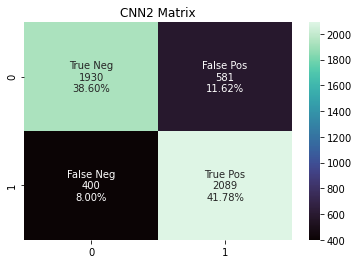

In [269]:
conf2 = confusion_matrix(y_true,y_pred2_classes)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf2.flatten()/np.sum(conf2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf2, annot=labels, fmt='',cmap='mako')
plt.title('CNN2 Matrix')
plt.show()

In [265]:
# predict probabilities for logistic regression
cnn2_probs = best_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
cnn2_probs = cnn2_probs[:,1]
# calculate scores
cnn2_auc = roc_auc_score(y_true, cnn2_probs)
cnn2_fpr, cnn2_tpr, _ = roc_curve(y_true, cnn2_probs)

Random Classifier: ROC AUC=0.500
Model2: ROC AUC=0.888


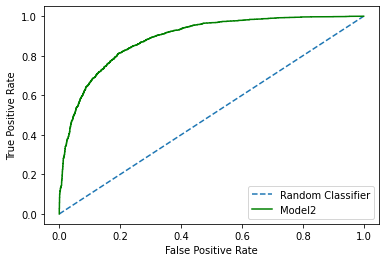

In [267]:
print('Random Classifier: ROC AUC=%.3f' % (rnd_auc))
print('Model2: ROC AUC=%.3f' % (cnn2_auc))
# plot the roc curve for the model
plt.plot(rnd_fpr, rnd_tpr, linestyle='--', label='Random Classifier')
plt.plot(cnn2_fpr, cnn2_tpr, marker='', label='Model2', color = 'g')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

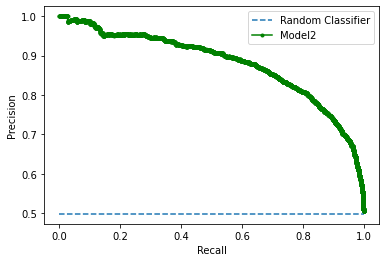

Model2: PR AUC=0.881


In [268]:
# plot the random classifier precision-recall curve
plt.plot([0, 1], [rnd, rnd], linestyle='--', label='Random Classifier')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, cnn2_probs)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='Model2', color = 'g')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
cnn2_pr_score = auc(recall, precision)
print('Model2: PR AUC=%.3f' % (cnn2_pr_score))

In [318]:
y_proba2 = best_model.predict(im_test)
y_values2 = y_proba2[:,0]

In [319]:
write_preds(y_values2, "cnn2.csv")

#### Model 2 performed fairly worse than model 1. The hyperband search may have found a better model after much more searching. However, the model performed well against the validation set compared to its internal evaluate feature

## Model 3

In [281]:
# Retrieve the 2nd best model from hyperparameter search.
best_model2 = best_model = tuner.get_best_models(num_models=3)[1]

In [278]:
best_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        3

In [282]:
# Evaluate the best model.
loss, accuracy = best_model2.evaluate(X_test, y_test)

157/157 [==============================] - 17s 109ms/step - loss: 0.4513 - accuracy: 0.7956


In [283]:
y_pred3 = best_model.predict(X_test)
y_pred3_classes = np.argmax(y_pred3, axis=1)

In [284]:
report3 = classification_report(y_true, y_pred3_classes, output_dict=True)
result3 = pd.DataFrame(report3).transpose()
result3

,precision,recall,f1-score,support
0,0.825536,0.751892,0.786995,2511.0000
1,0.770365,0.839695,0.803537,2489.0000
accuracy,0.795600,0.795600,0.795600,0.7956
macro avg,0.797950,0.795793,0.795266,5000.0000
weighted avg,0.798072,0.795600,0.795229,5000.0000


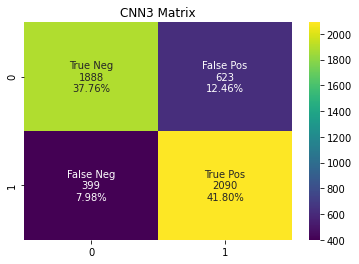

In [287]:
conf3 = confusion_matrix(y_true,y_pred3_classes)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf3.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf3.flatten()/np.sum(conf3)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf3, annot=labels, fmt='', cmap='viridis')
plt.title('CNN3 Matrix')
plt.show()

In [288]:
# predict probabilities for logistic regression
cnn3_probs = best_model2.predict_proba(X_test)
# keep probabilities for the positive outcome only
cnn3_probs = cnn3_probs[:,1]
# calculate scores
cnn3_auc = roc_auc_score(y_true, cnn3_probs)
cnn3_fpr, cnn3_tpr, _ = roc_curve(y_true, cnn3_probs)

Random Classifier: ROC AUC=0.500
Model3: ROC AUC=0.878


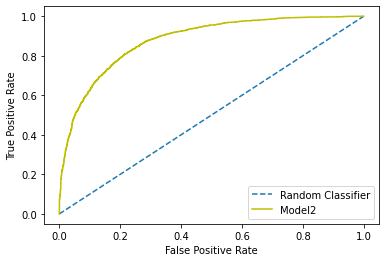

In [289]:
print('Random Classifier: ROC AUC=%.3f' % (rnd_auc))
print('Model3: ROC AUC=%.3f' % (cnn3_auc))
# plot the roc curve for the model
plt.plot(rnd_fpr, rnd_tpr, linestyle='--', label='Random Classifier')
plt.plot(cnn3_fpr, cnn3_tpr, marker='', label='Model2', color = 'y')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

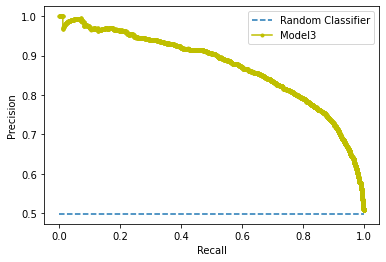

Model3: PR AUC=0.872


In [292]:
# plot the random classifier precision-recall curve
plt.plot([0, 1], [rnd, rnd], linestyle='--', label='Random Classifier')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, cnn3_probs)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='Model3', color = 'y')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
cnn3_pr_score = auc(recall, precision)
print('Model3: PR AUC=%.3f' % (cnn3_pr_score))

In [320]:
y_proba3 = best_model2.predict(im_test)
y_values3 = y_proba3[:,0]

#### Model 3 was expected to perform worse than model 2 since it was recieved as the second best model after the hyperparameter search. However, it only performed slightly worse by a whole point in AUC score.

In [321]:
write_preds(y_values3, "cnn3.csv")